# General Introduction

Monitoring Changes in Surface Water Using Satellite Image Data : Deliverable 1

For section: 1: Getting Started

Who: WuLung Hsu, 2020/11/15

Features: 

*   Get years of satellite image of reservoir nearby.
*   adjust the pixel value
*   Show it and import to Keras



# Setup & Maintain

In [ ]:
!pip install sentinelhub
!pip install utils
!pip install tensorflow
!pip install rasterio

Maintain data may need to use

In [100]:
#!rm -rf  test_dir
#!zip -r test_dir.zip test_dir

# Download from Sentinel Hub, Manually upload to google drive (can skip)

Init for sentinelhub

In [101]:
from sentinelhub import SHConfig
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, bbox_to_dimensions, DownloadRequest

# In case you put the credentials into the configuration file you can leave this unchanged

CLIENT_ID = '<client_id>'
CLIENT_SECRET = '<secret>'

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")



Download satellite data to disk

In [102]:
def gen_slots(pars):
  start = pars['start']
  end = pars['end']
  n_chunks = pars['n_chunks']

  tdelta = (end - start) / n_chunks
  edges = [(start + i*tdelta).date().isoformat() for i in range(n_chunks+1)]
  #print(edges)
  slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]
  print('Monthly time windows:\n')
  for slot in slots:
      print(slot)
  return slots

def get_true_color_request(time_interval,pars):
  name = pars['dir_name']
  reservoir_wgs84 = pars['wgs84'] #[121.021, 24.708, 121.128, 24.764]
  resolution = pars['resolution'] #Resolution of desired image in meters
  reservoir_bbox = BBox(bbox=reservoir_wgs84, crs=CRS.WGS84)
  reservoir_size = bbox_to_dimensions(reservoir_bbox, resolution=resolution)
  evalscript_true_color = """
      //VERSION=3

      function setup() {
          return {
              input: [{
                  bands: ["B02", "B03", "B04"]
              }],
              output: {
                  bands: 3
              }
          };
      }

      function evaluatePixel(sample) {
          return [sample.B04, sample.B03, sample.B02];
      }
  """
  return SentinelHubRequest(
      evalscript=evalscript_true_color,
      input_data=[
          SentinelHubRequest.input_data(
              data_collection=DataCollection.SENTINEL2_L1C,
              time_interval=time_interval,
              mosaicking_order='leastCC'
          )
      ],
      responses=[
          SentinelHubRequest.output_response('default', MimeType.PNG)
      ],
      bbox=reservoir_bbox,
      size=reservoir_size,
      config=config,
      data_folder='test_dir/%s' %(name),
  )

#init pars
pars = {
    "dir_name": "2018",
    "start": datetime.datetime(2018,1,1), 
    "end": datetime.datetime(2018,12,31), 
    "n_chunks": 12 ,
    "wgs84": [121.021, 24.708, 121.128, 24.764],
    "resolution": 60,
    } 
# create a list of requests
for year in range(2017,2020):
  pars["dir_name"]=str(year)
  pars["start"]=datetime.datetime(year,1,1) 
  pars["end"]= datetime.datetime(year,12,31)
  slots = gen_slots(pars)
  list_of_requests = [get_true_color_request(slot,pars) for slot in slots]
  list_of_requests = [request.download_list[0] for request in list_of_requests]

  # download data with multiple threads
  data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)


Monthly time windows:

('2017-01-01', '2017-01-31')
('2017-01-31', '2017-03-02')
('2017-03-02', '2017-04-02')
('2017-04-02', '2017-05-02')
('2017-05-02', '2017-06-01')
('2017-06-01', '2017-07-02')
('2017-07-02', '2017-08-01')
('2017-08-01', '2017-08-31')
('2017-08-31', '2017-10-01')
('2017-10-01', '2017-10-31')
('2017-10-31', '2017-11-30')
('2017-11-30', '2017-12-31')
Monthly time windows:

('2018-01-01', '2018-01-31')
('2018-01-31', '2018-03-02')
('2018-03-02', '2018-04-02')
('2018-04-02', '2018-05-02')
('2018-05-02', '2018-06-01')
('2018-06-01', '2018-07-02')
('2018-07-02', '2018-08-01')
('2018-08-01', '2018-08-31')
('2018-08-31', '2018-10-01')
('2018-10-01', '2018-10-31')
('2018-10-31', '2018-11-30')
('2018-11-30', '2018-12-31')
Monthly time windows:

('2019-01-01', '2019-01-31')
('2019-01-31', '2019-03-02')
('2019-03-02', '2019-04-02')
('2019-04-02', '2019-05-02')
('2019-05-02', '2019-06-01')
('2019-06-01', '2019-07-02')
('2019-07-02', '2019-08-01')
('2019-08-01', '2019-08-31')
('2

Pack to zip

In [ ]:
!zip -r test_dir.zip test_dir

Manually download to disk, upload to google drive

# Download from google drive, adjust image and plot it

In [104]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

#download from google drive
file_id = '16avvC35LmzzRrw-weFcgZBmaH-0SyXlY'
destination = '/content/test_dir.zip'
download_file_from_google_drive(file_id, destination)

#unzip
import zipfile
with zipfile.ZipFile(destination,"r") as zip_ref:
    zip_ref.extractall("/content")



*   Modify images
*   Modify dir name with time frame information



In [106]:
from pathlib import Path
from PIL import Image
import os
import json
def get_image_title(img_path):
  filename = os.path.join(os.path.dirname(img_path),"request.json")
  with open(filename, 'r') as json_file:
    data_head = json.load(json_file)

  str_from = str(data_head['payload']['input']['data'][0]['dataFilter']['timeRange']['from'])
  str_to = str(data_head['payload']['input']['data'][0]['dataFilter']['timeRange']['to'])
  return "%s_%s" %(str_from,str_to)

p = Path('/content/')
img_list = list(p.glob('**/*.png'))

# modify dirname to time frame
for img_path in img_list:
  title = get_image_title(img_path) 
  old = os.path.dirname(img_path)
  new = os.path.join(os.path.dirname(old),title)
  #print("%s,%s" %(old,new))
  if old!=new:
    img = Image.open(img_path)
    out = img.point(lambda i: i * 1.2) #check point, modify image
    out.save(img_path)
    os.rename(old,new)



Plot image to preview

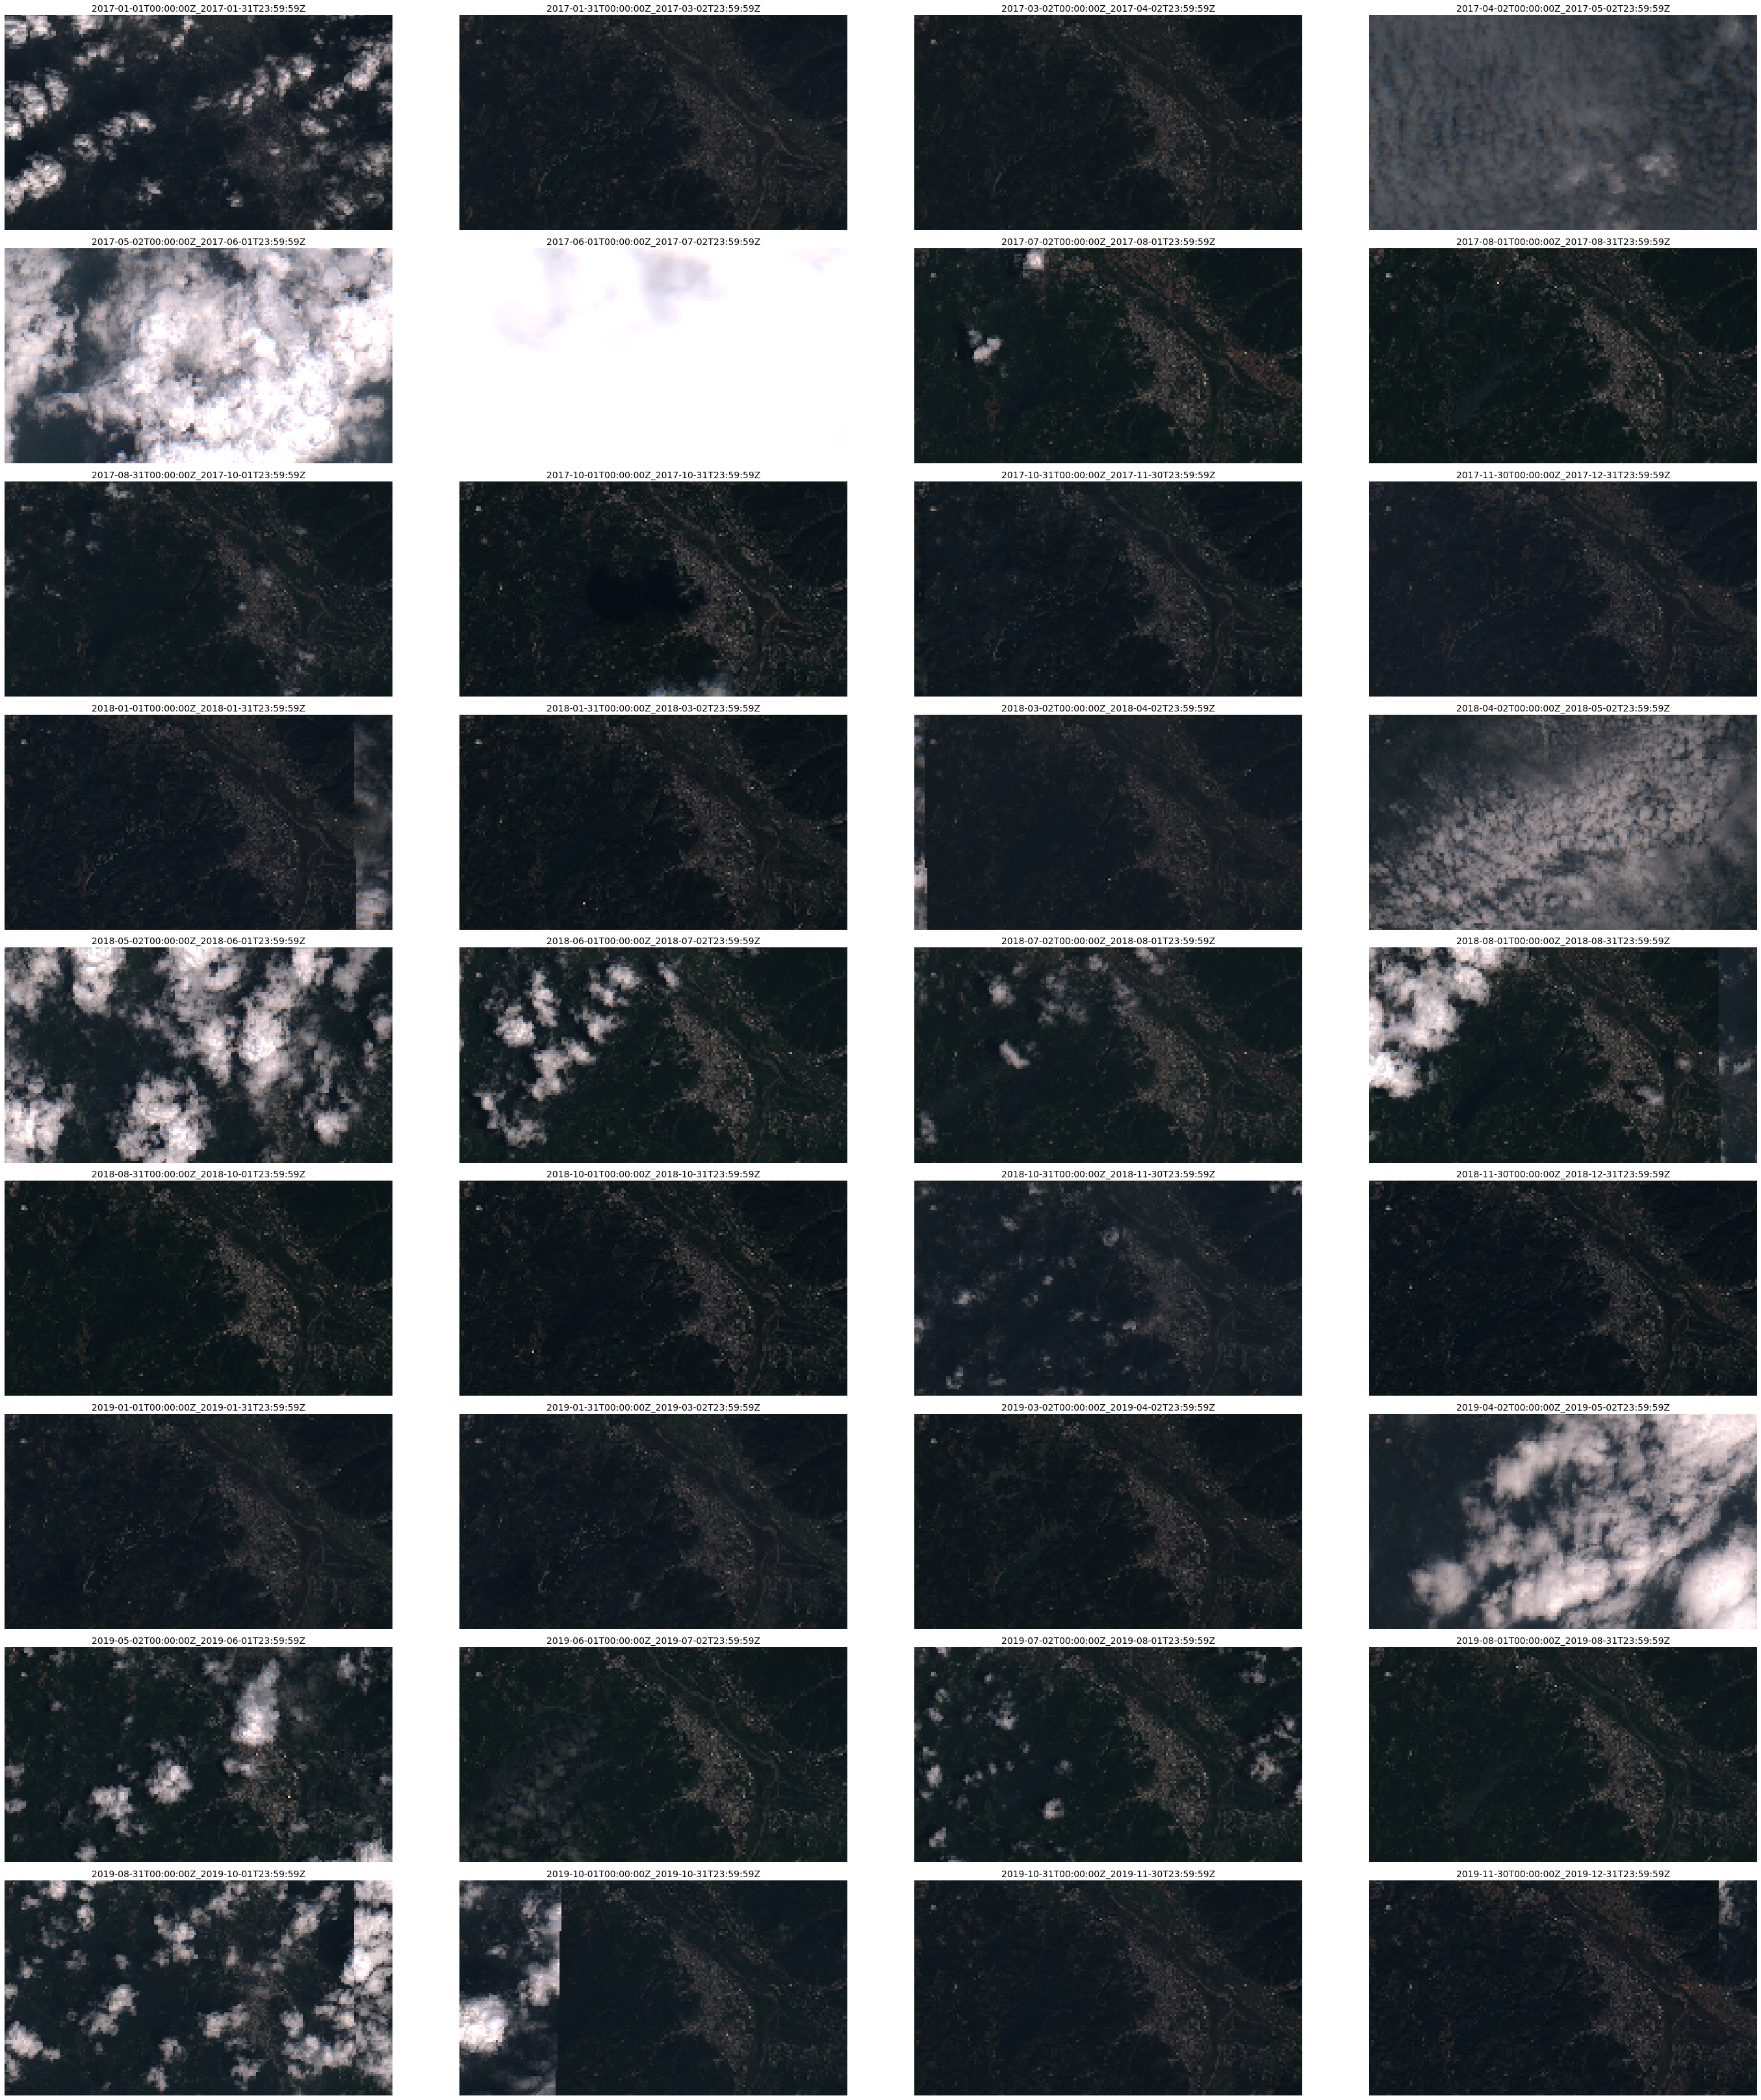

In [107]:
p = Path('/content/')
img_list = list(p.glob('**/*.png'))
img_list.sort()
# some stuff for pretty plots
ncols = 4
nrows = int(len(img_list)/ncols)
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows,figsize=(5 * ncols * 2, 5 * nrows), subplot_kw=subplot_kw)

for idx in range(len(img_list)):
  img_path = img_list[idx]
  ax = axs[idx // ncols][idx % ncols]
  image = mpimg.imread(img_path)
  #ax.imshow(np.clip(image * 2.5/255, 0, 1))
  ax.imshow(image)
  ax.set_title(get_image_title(img_path), fontsize=14)
plt.tight_layout()

# Import to Keras

In [108]:
import tensorflow as tf
IMAGE_SIZE=128
BATCH_SIZE=32
base_dir="/content/test_dir"
train_gen = tf.keras.preprocessing.image.ImageDataGenerator()
train_generator = train_gen.flow_from_directory(base_dir,target_size=(IMAGE_SIZE, IMAGE_SIZE),batch_size=BATCH_SIZE, subset='training')

Found 36 images belonging to 3 classes.


In [99]:
train_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

# Read raster image by rasterio

Download raster example with tiff format

In [114]:
reservoir_wgs84 = [121.021, 24.708, 121.128, 24.764]
resolution = 60 #Resolution of desired image in meters
reservoir_bbox = BBox(bbox=reservoir_wgs84, crs=CRS.WGS84)
reservoir_size = bbox_to_dimensions(reservoir_bbox, resolution=resolution)

evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""


request_all_bands = SentinelHubRequest(
    data_folder='test_dir2',
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-06-01', '2020-06-30'),
            mosaicking_order='leastCC'
    )],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=reservoir_bbox,
    size=reservoir_size,
    config=config
)
import os
all_bands_img = request_all_bands.get_data(save_data=True)

print(f'The output directory has been created and a tiff file with all 13 bands was saved into ' \
      'the following structure:\n')
request_all_bands.save_data()

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

test_dir2/28be113f1f9cbc31098da7cbccf7ef77/request.json
test_dir2/28be113f1f9cbc31098da7cbccf7ef77/response.tiff


Read raster information

In [115]:
import rasterio
import glob
import os
fp = "/content/test_dir2/28be113f1f9cbc31098da7cbccf7ef77/response.tiff"
raster = rasterio.open(fp)
raster.meta

{'count': 13,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 101,
 'nodata': None,
 'transform': Affine(0.0005879120879120842, 0.0, 121.021,
       0.0, -0.0005544554455445637, 24.764),
 'width': 182}